## Milestone 4: Baseline Model and Pipeline


**Project 57**<br/>
**Due: November 27, 2023**<br/>
**Team**: Hannah Boen, Gabe LeBlanc, Ethan Tran

---

#### Resources
- BRFSS dataset from proposal: https://www.cdc.gov/brfss/annual_data/annual_data.htm
- Referenced codebooks from link above
- BRFSS files in accessible csv format: https://osf.io/6rxf4/
- Used 2017-2021 data from link above

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [2]:
# Filter out FutureWarnings
from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

# Globally set figure size
plt.rcParams["figure.figsize"] = (15,6)

## Problem Statement

Which factors best predict an individual's mental health outcomes in the United States? Specifically, which of six categories (sex, education level, race, annual household income, employment, and geography) is most correlated with the number of days per month an individual struggles with stress, depression, or their emotions? Further, which (if any) of these factors interact to have a combined impact on mental health, and how have those relationships changed between 2017 and 2021?

## Explore and Visualize Data

#### Data cleaning function

In [3]:
def clean_data(year):

    predictors = []
    predictors.append("sex" if year == 2017 else "sex1" if year == 2018 else "sexvar") 
    predictors.append("_race_g1" if year in [2017, 2018, 2019] else "_raceprv") 
    predictors.append("_cprace1" if year == 2021 else "_cprace")
    predictors.append("income3" if year == 2021 else "income2")
    predictors.append("_incomg1" if year == 2021 else "_incomg") 
    predictors += ["_imprace", "educa", "_educag", "employ1", "_state", "_chispnc", "_crace1"]
    predictors += ["_prace1", "_mrace1", "_race", "_raceg21", "_racegr3", "renthom1", "veteran3", "mscode"]

    predictors += ["colgsex", "landsex", "cellsex"]

    orig_df = pd.read_csv(f"data/BRFSS{year}.csv", low_memory=False)

    if year not in [2019, 2020, 2021]:
        orig_df = orig_df.assign(colgsex=float('nan'))
        orig_df = orig_df.assign(landsex=float('nan'))
        orig_df = orig_df.assign(cellsex=float('nan'))

    selected_columns = predictors + ["menthlth"]

    print(f"Year {year} data loaded!")
    
    return orig_df[selected_columns]
    

In [4]:
#Clean years of interest and rename columns for easy interpretation
def restructure_data():

    warnings.filterwarnings("ignore", category=UserWarning)
    
    years = [2017, 2018, 2019, 2020, 2021]
    cleaned_dfs = []
    
    for year in years:
        cleaned_df = clean_data(year)
        cleaned_df["year"] = year
    
        if "_cprace1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_cprace1": "_cprace"})
    
        if "income3" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"income3": "income2"})
    
        if "_race_g1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_race_g1": "_raceprv"})
    
        if "_incomg1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_incomg1": "_incomg"})
    
        if "sex1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"sex1": "sex"})
    
        if "sexvar" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"sexvar": "sex"})
        
        if "income2" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"income2": "household_income"})
    
        if "educa" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"educa": "education"})
    
        if "_imprace" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"_imprace": "imputed_race"})
    
        if "employ1" in cleaned_df:
            cleaned_df = cleaned_df.rename(columns={"employ1": "employment"})
    
        cleaned_dfs.append(cleaned_df)

    return cleaned_dfs

In [5]:
def remove_missingness(df):

    df.loc[df["renthom1"] > 3, "renthom1"] = float('nan')

    df.loc[df["_incomg"] == 6, "_incomg"] = 5
    df.loc[df["_incomg"] == 7, "_incomg"] = 5
    df.loc[df["_incomg"] > 5, "_incomg"] = float('nan')

    df.loc[df["menthlth"] == 88, "menthlth"] = 0
    df.loc[df["menthlth"] > 30, "menthlth"] = float('nan')

    df.loc[df["_cprace"] > 7, "_cprace"] = float('nan')

    df.loc[df["household_income"] == 9, "household_income"] = 8
    df.loc[df["household_income"] == 10, "household_income"] = 8
    df.loc[df["household_income"] == 11, "household_income"] = 8

    df.loc[df["household_income"] > 8, "household_income"] = float('nan')

    df.loc[df["landsex"] > 3, "landsex"] = float('nan')

    df.loc[df["_educag"] > 5, "_educag"] = float('nan')

    df.loc[df["_crace1"] > 7, "_crace1"] = float('nan')

    df.loc[df["cellsex"] > 3, "cellsex"] = float('nan')

    df.loc[df["_race"] > 8, "_race"] = float('nan')

    df.loc[df["_racegr3"] == 9, "_racegr3"] = float('nan')

    df.loc[df["employment"] == 9, "employment"] = float('nan')

    df.loc[df["_prace1"] == 99, "_prace1"] = float('nan')
    df.loc[df["_prace1"] == 8, "_prace1"] = float('nan')

    # careful not to drop in all cases like this, with so many 9s
    df.loc[df["_chispnc"] == 9, "_chispnc"] = float('nan')

    df.loc[df["_raceg21"] == 9, "_raceg21"] = float('nan')

    df.loc[df["education"] == 9, "education"] = float('nan')

    df.loc[df["veteran3"] > 6, "veteran3"] = float('nan')

    df.loc[df["_mrace1"] > 7, "_mrace1"] = float('nan')

    df.loc[df["sex"] > 6, "sex"] = float('nan')

    return df
    
    # we will also need to adjust our variables to prevent accidental treatment as ordinal
    # we will later test whether missingness variables matter by creating a missingness column; for now we drop all

In [6]:
def concatenate_data(cleaned_dfs):
    #Concatenate for one large df, keeping only variables consistent throughout all years of interest
    common_columns = set(cleaned_dfs[0].columns)
    for df in cleaned_dfs[1:]:
        common_columns = common_columns.intersection(df.columns)
    final_df = pd.concat([df[list(common_columns)] for df in cleaned_dfs], axis=0, ignore_index=True)
    return final_df
    # final_df.set_index("year", inplace=True)

### Collinearity Matrix

See milestone 3 for accompanying code.

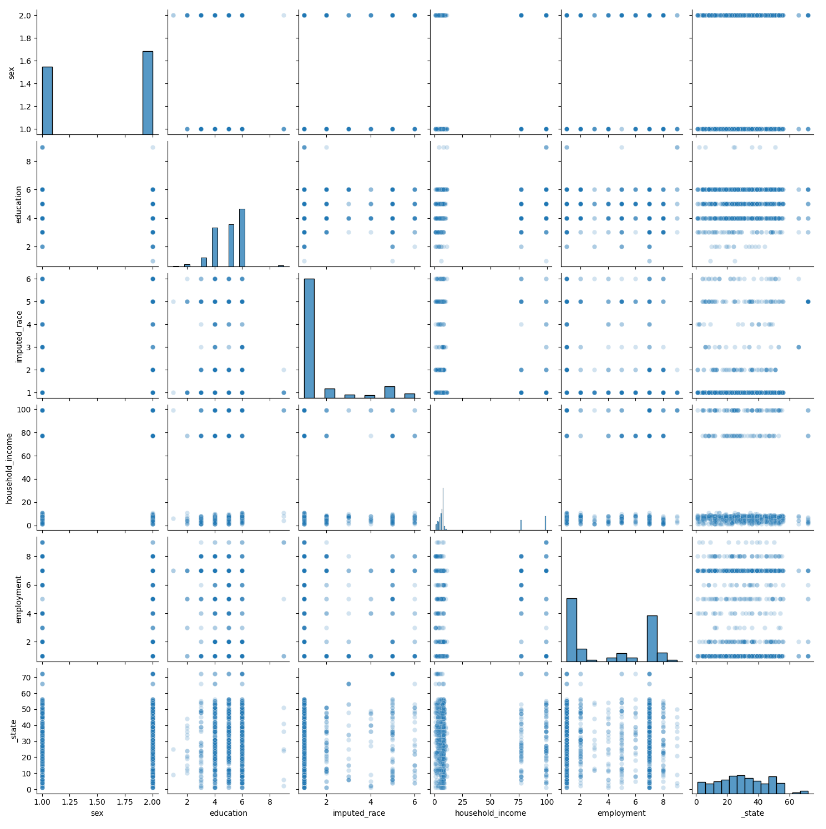

It is difficult to identify any clear correlation among predictors, which may mean each predictor is significant enough to be considered.

One potential issue involves treating categorical values as ordinal (for instance, treating race as ordered integers), so we'll have to be cautious about identifying any linear relationships and potentially readjust our predictor values as well.

### Correlation Matrix

See milestone 3 for accompanying code. 

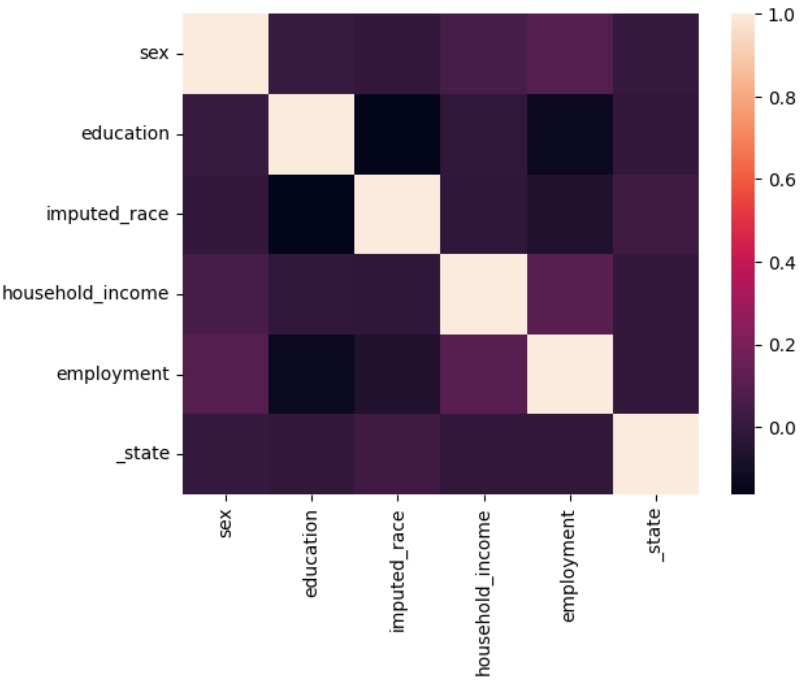

We confirm here that our primary variables have very little correlation, so our models should avoid collinearity using these predictors.

We can also confirm here that our subpredictors are correlateed with our primary predictors:

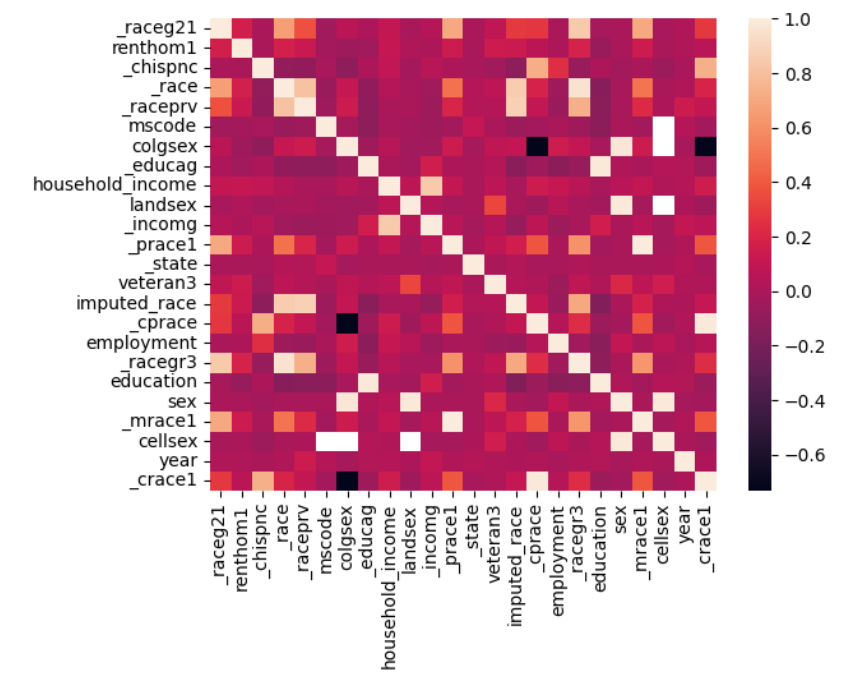

For instance, education is correlation with _educag (a subpredictor of education), race predictors are often correlated (i.e. _crace1 and _cprace), and sex predictors are correlated too (i.e. colgsex, a subpredictor of sex).

### Variables of Interest

After checking for missingness and visualizing predictor / response relationships (see Milestone 3), we determined that the following were our primary predictors:

In [7]:
primary_predictors = ["sex", "education", "imputed_race", "household_income", "employment", "_state", "menthlth"]


### Notes on Data Imbalances and Resampling

We see that there are certain absolute and/or simple majorities present in each explored variable of interest. Females are the absolute majority sex, college graduates are the simple majority education level, and whites (non-Hispanics) are the absolute majority imputed race. While it is possible to resample the data and create a balanced dataset, we decided not to resample the data at this time in order to maintain the representativeness and interpretability of the dataset.

For example, there is a slightly larger percentage of females than males in the USA and the US Census Bureau estimated that the USA was ~75% white in 2022 which aligns with the percentages on our graphs. The aim is to reflect real-world demographics and ensure that our findings are applicable to broader populations. By not artificially balancing the data, we preserve the natural variations in demographic factors. We will instead address these imbalances by ensuring that each class is adequately represented in both training and testing sets.

The line graphs depicting percentages of sex, education, and imputed race variables of interest consistently show similar patterns over the five-year period, appearing as horizontal lines for each response. The stability in these percentages raises questions about potential data calculation errors or variations in data collection methods. Given the relatively short timeframe and minimal reported changes in data collection processes, it is possible that these findings reflect the consistent nature of these demographic attributes throughout the five-year span. This is something we will further analyze in future work.

## Baseline Model
Here, we define functions to split our data and create a Linear Regression as our baseline model.

In [8]:
def split_data(final_df):
    variables = ["sex", "education", "imputed_race", "household_income", "employment", "_state", "menthlth"]
    
    print(f'{len(final_df[variables]) - len(final_df[variables].dropna())} entries with missing data')
    
    data_train, data_test = train_test_split(
        final_df[variables].dropna(),
        test_size=0.2,
        random_state=121,
        shuffle=True
    )
    
    X_train, y_train = data_train.drop(columns=["menthlth"]), data_train["menthlth"] 
    X_test, y_test = data_test.drop(columns=["menthlth"]), data_test["menthlth"]
    
    return X_train, X_test, y_train, y_test

In [9]:
def train_linear(X_train, X_test, y_train, y_test):
    predictors = ["sex", "education", "imputed_race", "household_income", "employment", "_state"]
    
    lin_reg = LinearRegression().fit(X_train[predictors], y_train)
    
    acc_train_lin_reg = lin_reg.score(X_train[predictors], y_train)
    acc_test_lin_reg = lin_reg.score(X_test[predictors], y_test)
    
    # Grab model's intercept and coefs regardless of their shape
    # (which depends on how x and y were shaped)
    lin_reg_intercept = np.array(lin_reg.intercept_).flatten()[0]
    lin_reg_coefs = lin_reg.coef_.flatten()
    
    print(
        "The intercept and coefficients for the 'baseline Linear Regression' model are:"
        "\n\n\t{:<20}{:.4f}".format(
            "intercept", lin_reg_intercept
        )
    )
    for predictor, coef in zip(predictors, lin_reg_coefs):
        print("\t{:<20}{:.4f}".format(predictor, coef))
    
    print(
        "\nThe classification accuracies for 'baseline Linear Regression' are:"
        "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
        .format(acc_train_lin_reg, acc_test_lin_reg)
    )

    return lin_reg

# Developing a Linear Regression

Here, we use the functions above (in a similar sequence to the pipeline below) to clean our data and test a linear regression model. We start to gauge how effective a Linear Regression may be in terms of best describing our dataset.

In [10]:
renamed_dfs = restructure_data()

Year 2017 data loaded!
Year 2018 data loaded!
Year 2019 data loaded!
Year 2020 data loaded!
Year 2021 data loaded!


In [11]:
cleaned_dfs = concatenate_data(renamed_dfs)

In [12]:
cleaned_dfs.head()

,colgsex,employment,mscode,_chispnc,_educag,_racegr3,_incomg,cellsex,_raceprv,_prace1,...,_crace1,veteran3,renthom1,_raceg21,household_income,education,_cprace,_mrace1,menthlth,_state
0,NaN,7.0,1.0,NaN,4,1.0,4,NaN,1.0,1.0,...,NaN,1.0,1.0,1.0,6.0,6.0,NaN,1.0,88.0,1
1,NaN,7.0,3.0,NaN,4,1.0,5,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,8.0,6.0,NaN,1.0,88.0,1
2,NaN,7.0,3.0,NaN,1,1.0,9,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,99.0,2.0,NaN,1.0,88.0,1
3,NaN,7.0,2.0,NaN,1,1.0,1,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,1.0,3.0,NaN,1.0,88.0,1
4,NaN,8.0,1.0,NaN,1,1.0,1,NaN,1.0,1.0,...,NaN,2.0,2.0,1.0,2.0,2.0,NaN,1.0,88.0,1


In [13]:
final_df = remove_missingness(cleaned_dfs)

In [14]:
final_df.head()

,colgsex,employment,mscode,_chispnc,_educag,_racegr3,_incomg,cellsex,_raceprv,_prace1,...,_crace1,veteran3,renthom1,_raceg21,household_income,education,_cprace,_mrace1,menthlth,_state
0,NaN,7.0,1.0,NaN,4.0,1.0,4.0,NaN,1.0,1.0,...,NaN,1.0,1.0,1.0,6.0,6.0,NaN,1.0,0.0,1
1,NaN,7.0,3.0,NaN,4.0,1.0,5.0,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,8.0,6.0,NaN,1.0,0.0,1
2,NaN,7.0,3.0,NaN,1.0,1.0,NaN,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,NaN,2.0,NaN,1.0,0.0,1
3,NaN,7.0,2.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,...,NaN,2.0,1.0,1.0,1.0,3.0,NaN,1.0,0.0,1
4,NaN,8.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,1.0,...,NaN,2.0,2.0,1.0,2.0,2.0,NaN,1.0,0.0,1


In [15]:
X_train, X_test, y_train, y_test = split_data(final_df)

440770 entries with missing data


We recognize that this is a substantial number of rows with missing data. Currently, we drop each of those rows in our split_data function to produce a linear regression. Though there are still well over 1.74 million usable rows in the dataset, we believe it would be better to impute many of those values instead. Robert, we'd love to meet with you to discuss what an appropriate imputation method would be!

## Creating a Model: Motivating Visuals

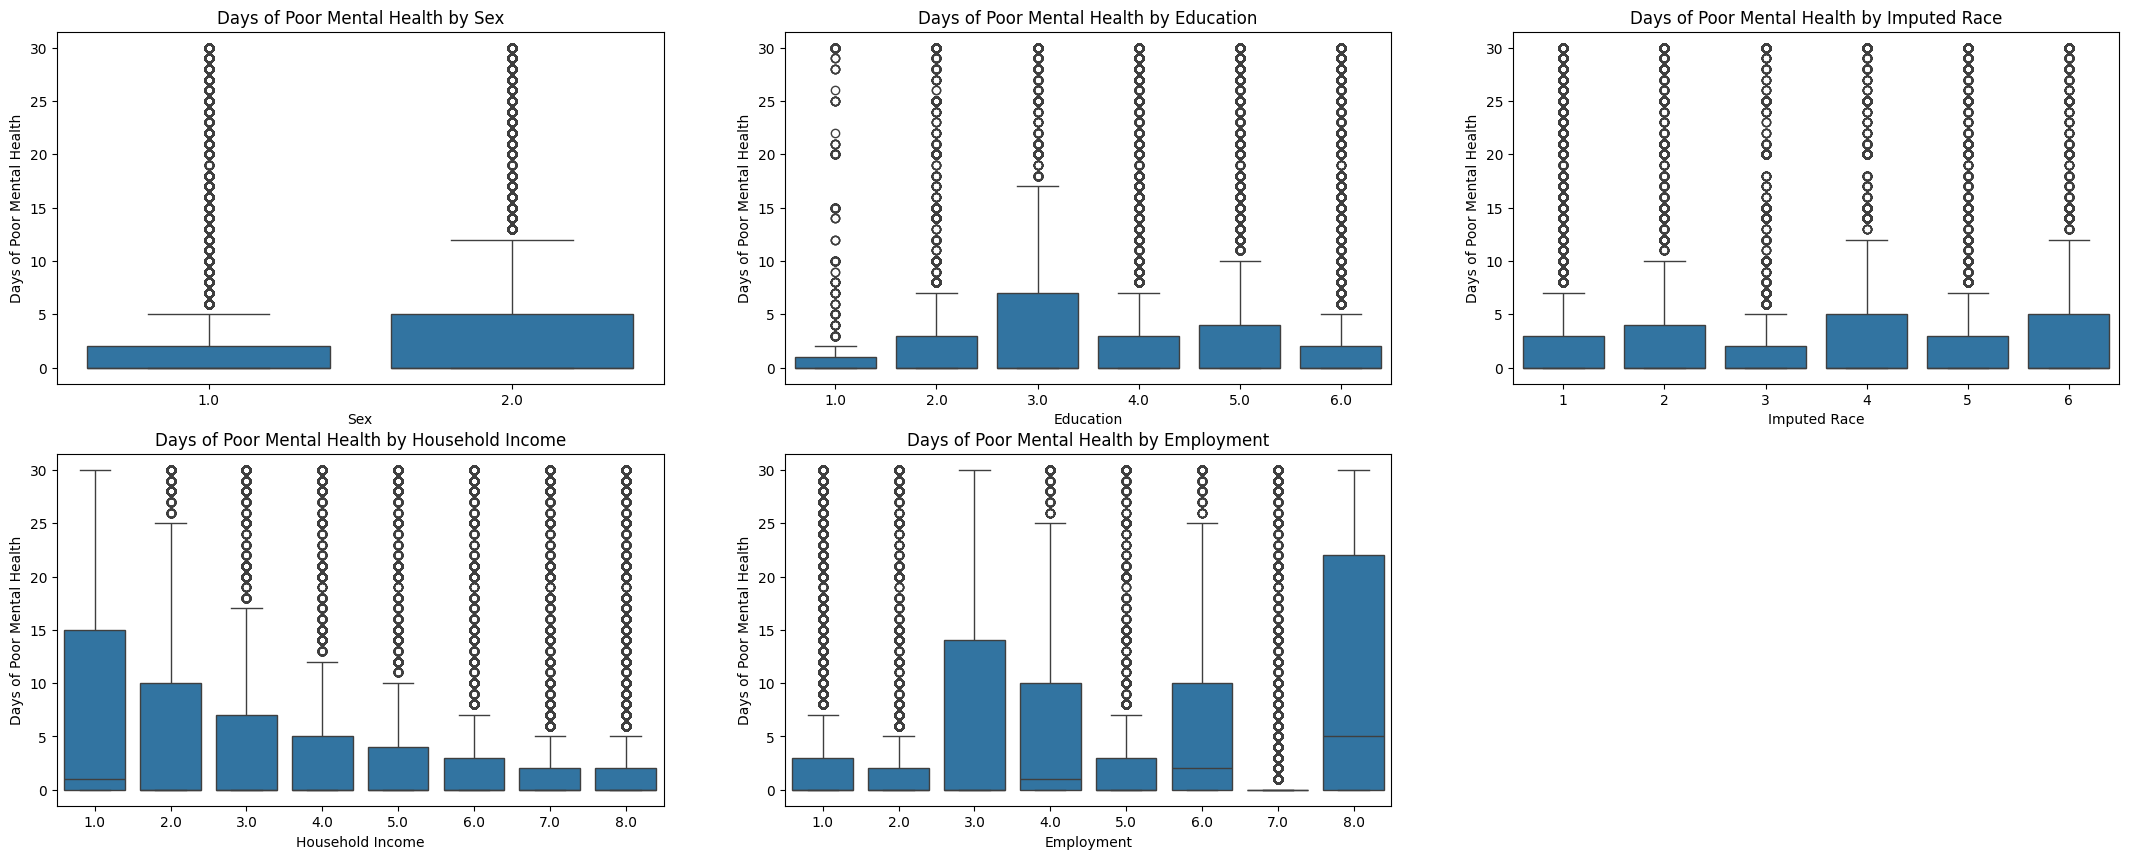

In [16]:
# Visualizations of relationship between predictors and response using boxplots
# Create box plots between each continuous predictor and 'admitted'

cat_predictors = X_train.columns[:-1]

for i in range(len(cat_predictors)):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x = X_train[cat_predictors[i]], y = y_train).set(xlabel = cat_predictors[i].title().replace("_", " "), ylabel = 'Days of Poor Mental Health', title = f'Days of Poor Mental Health by {cat_predictors[i].title().replace("_", " ")}')

plt.subplots_adjust(right = 1.5, top = 1.4)

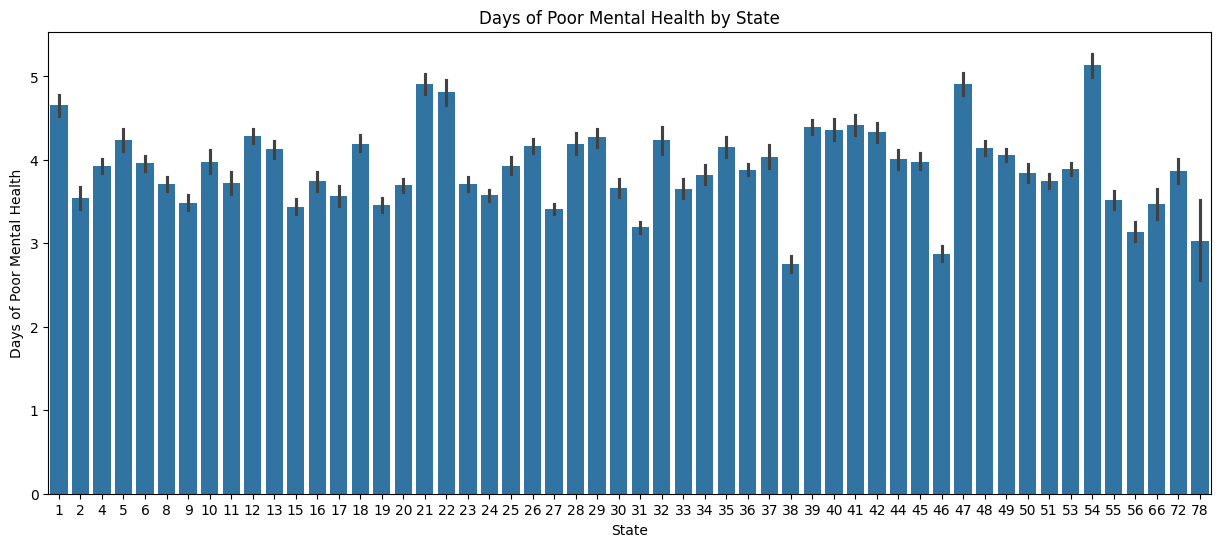

In [17]:
sns.barplot(x = X_train['_state'], y = y_train).set(xlabel = "State", ylabel = "Days of Poor Mental Health", title = 'Days of Poor Mental Health by State');

## Interpreting Results

As can be seen in these plots above each of our predictors have a clear relationship to 'menthlth,' or in other words, the number of days of poor mental experienced by a respondent within the past 30 days.


- **Sex**: It can be seen that those with a value of 2 for the sex variable, ie. respondents assigned female at birth, have a median of around 13 days with poor mental health, which is over double the amount for those with a value of 1 for the sex variable, or those assigned male at birth.


- **Education**: Those individuals with values of 3, Grades 9 through 11 (Some high school), and 5, College 1 year to 3 years (Some college or
technical school), had the highest and second highest median number of days with poor mental health. This makes sense, as those years encapsulate times of great transition from lower levels of schooling to new, higher levels of schooling. Values of 4, Grade 12 or GED (High school graduate), or 6, College 4 years or more (College graduate), have vastly lower median numbers of poor mental days. It may be that high schoolers and undergraduates are working hard and accumulating stress over the course of their freshman to junior years of school before finally being able to relax upon college admission/confirmation of postgraduate plans. As for 1, Never attended school or only kindergarten, there are few observations in this category and it is likely that the researchers and parent respondents were unable to accurately poll their young children for mental health (and the children may not be equipped to count beyond 10). Funnily enough the last category, those with a value of 2, or Grades 1 through 8 (Elementary), have a similar median number of poor mental health days as those with values of 4 and 6. 


- **Race (Imputed)**: Compared to the majority white population (those with a value of 1), Black Americans (2), Asian Americans (4), and Other race Non-Hispanics (6) have higher median numbers of poor mental health days. The remaining categories, American Indians/Alaskan Natives (3), and Native Hawaiian or other Pacific Islander Americans (5), have around the same or lower median numbers of poor mental health days, though it is important to note that they have much lower response rates and it is likely that the effects of the non-response bias within these populations may be stronger than it others. In a report titled "No Connection: The Issue of Internet on the Reservation," the researchers write that "Only 68% of
those living on rural reservations have telephone service," (Donnellan 2017:351). In this case, it is likely only the most wealthy among these populations that are able to respond to the BRFSS. Wealth is a very important predictor of mental health, as will be explained below.


- **Household Income**: There is a strong negative relationship between one's household income and the number of poor mental health days they report experiencing within the thirty days prior to interview. From values of 1, Less than $10,000, to values of 8, $75,000 or more, the median number of poor mental health days experienced declines from around 30 days to aruond 5. There is a clear correlation between improvements in mental health and household income.


- **Employment**: Out of the 8 categories, 3, Out of work for 1 year or more, 4, Out of work for less than 1 year, 6, Student, and 8, Unable to Work, have the highest median number of poor mental health days. In descending order are those Unable to Work, those Out of Work for 1 year or more, Students, and finally Those Out of work for less than 1 year. As can be seen here, unemployment is correlated with poorer mental health. 


- **State**: Out of the 50 states and 4 territories (including Washington, D.C.), the states with the highest median number of poor mental health days are in descending order: West Virginia (54), Tennesee (47), Kentucky (21), Louisiana (22), and Alabama (01). These states are primarily in the Southeastern United States and are among the bottom 10 states in terms of median household income according to the [World Population Review](https://worldpopulationreview.com/state-rankings/median-household-income-by-state). As we have seen above that household income is strongly correlated with median number of poor mental health days it is no wonder then that states with lower median incomes also have higher median numbers of days with poor mental health.

In [18]:
lin_reg = train_linear(X_train, X_test, y_train, y_test)

The intercept and coefficients for the 'baseline Linear Regression' model are:

	intercept           6.8291
	sex                 1.0799
	education           -0.0426
	imputed_race        -0.0146
	household_income    -0.7000
	employment          -0.0178
	_state              -0.0023

The classification accuracies for 'baseline Linear Regression' are:

	Train	0.0398
	TEST	0.0385


Here is an example of how our linear regression performs on one predictor, household_income. Once we fix the numbering of our variables, we'll be able to properly train on more than one predictor. 

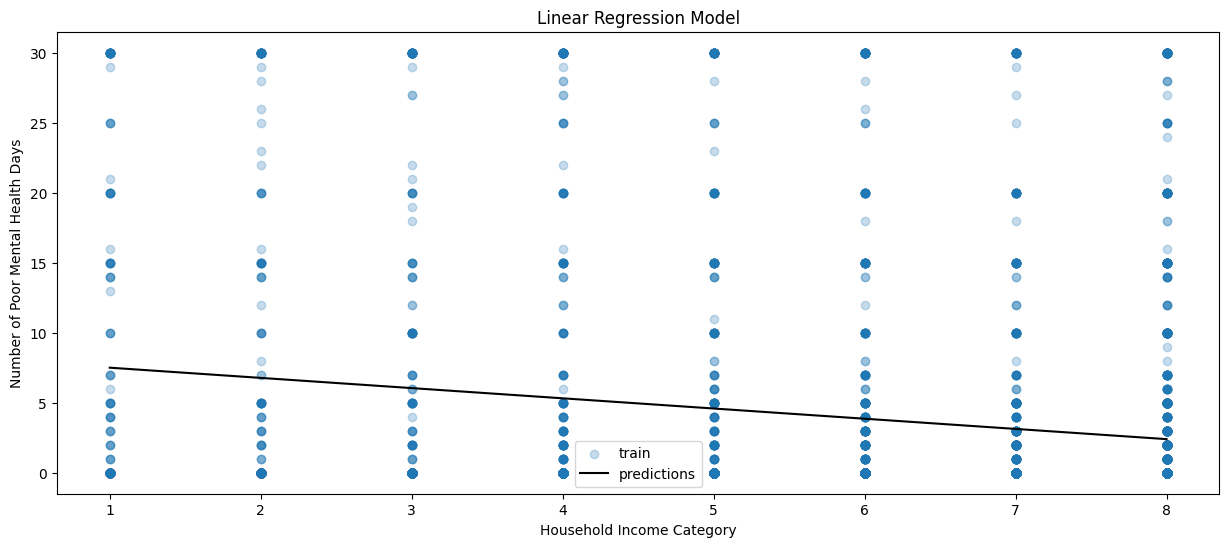

In [19]:
# Visualize Linear Regression over each year
X_temp = X_train.head(5000)
y_temp = y_train.head(5000)
lin_reg2 = LinearRegression().fit(pd.DataFrame(X_temp["household_income"]), y_temp)
x_lin = np.linspace(pd.DataFrame(X_temp["household_income"]).min(), pd.DataFrame(X_temp["household_income"]).max(), 1000)
y_pred = lin_reg2.predict(x_lin)
plt.scatter(X_temp["household_income"], pd.DataFrame(y_temp), alpha=0.25, label='train')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('Household Income Category')
plt.ylabel('Number of Poor Mental Health Days')
plt.title('Linear Regression Model')
plt.legend();

## Interpreting Results

Other than the variables with arbitrary ordering that we'll account for in the future, these intercepts largely make sense. It seems that rising houshold income is associated with a decline in poor mental health days, as is gaining education or employment. Logically, these make sense, because they place people in a position of better financial and emotional security, likely leading to better mental health outcomes. It seems that a linear model does make sense, though we'll have to investigate further (especially to see if there is a need for polynomial features), especially once we fix the numbering of variables.

Note that our classification accuracies are very low here, but that is to be expected: given that our response variable has 30 possible values, and the difference between, say, 29 and 30 days of poor mental health is largely trivial, we're more interested in seeing if our model predicts a value *close* to the actual number of days. 

The linear regression visualization above also supports that a linear regression may be reasonable - generally, there is a higher concentration of data points in the lower right corner than the lower left corner, meaning people with higher incomes to seem to have fewer poor mental health days. 

For our final steps, we'll adjust our predictor numbering, fine-tune our linear regression model (and train additional models as necessary), and potentially investigate these trends relative to our year variable as well. 

## Pipeline

Below is a function representing the full pipeline of our model as currently designed. 

In [21]:
def pipeline():

    # Load data and handle discrepancies between years
    renamed_dfs = restructure_data()

    # Concatenate all years into one dataframe
    cleaned_dfs = concatenate_data(renamed_dfs)

    # Handle missing values that are not blank
    final_df = remove_missingness(cleaned_dfs)

    # Handle missingness and split data
    X_train, X_test, y_train, y_test = split_data(final_df)

    # Train a linear regression model and print intercepts
    lin_reg = train_linear(X_train, X_test, y_train, y_test)

    return lin_reg
    